/home/rocm-user/.local/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/rocm-user/.local/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

pygame 2.4.0 (SDL 2.26.4, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


100%|██████████| 1611/1611 [00:02<00:00, 609.63it/s]


Usable font: 1589


ValueError: Could not generate font metrics for 名雷氏钝𫚥虎鱼，为条鳍鱼纲鲈形目𫚥虎科钝𫚥虎鱼属下的一个种，该物种主要西太平洋热带海域，体长可达85公分。

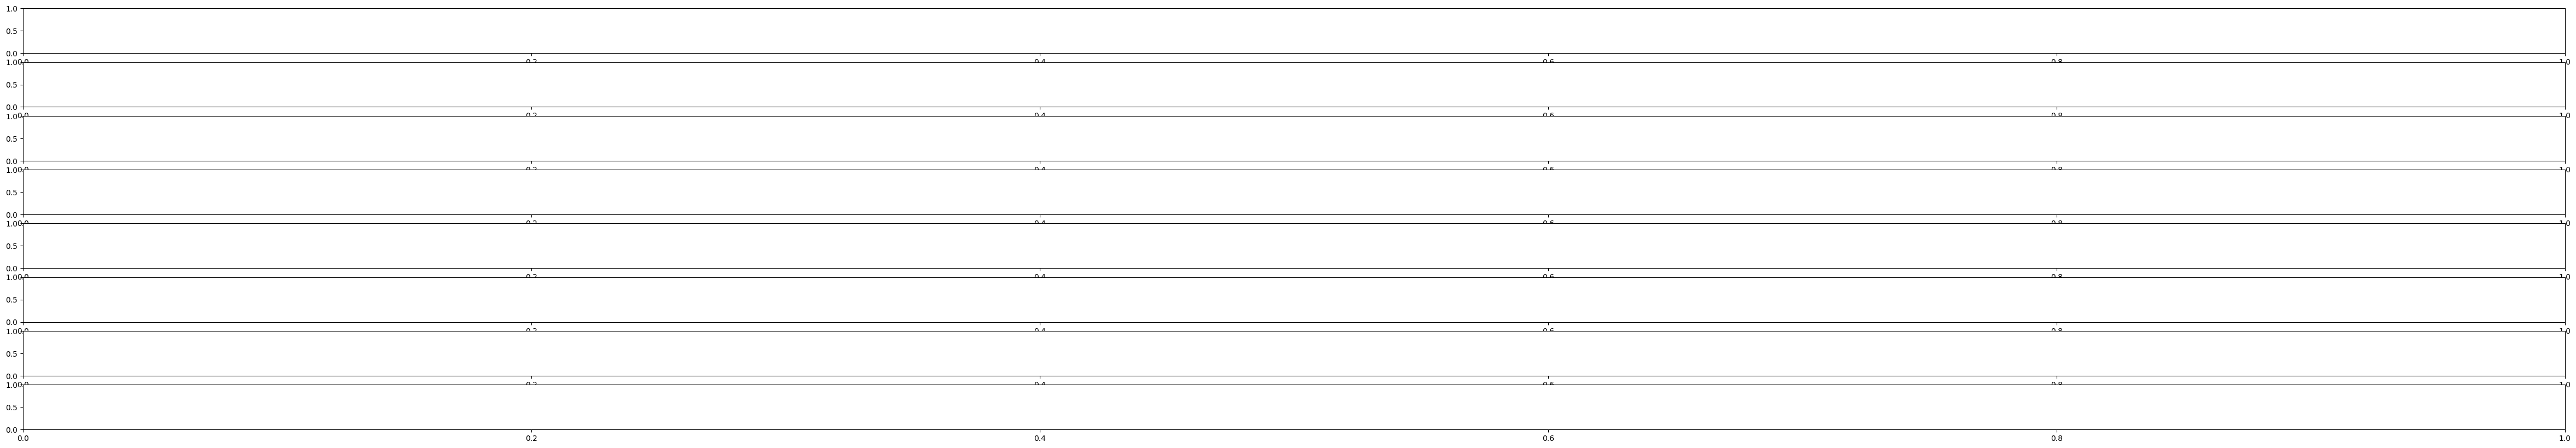

In [1]:
import random

import matplotlib.pyplot as plt
import cv2
from PIL import Image

from data_aug_v2 import build_data_aug
from tang_syn import synthesize

# message = "有人Hello Pygame你的心里没有人心心"
# message = "你好， 안녕 שָׁלוֹם 🎉🌟🙌😄！"


# transform = build_data_aug(32, "train")
# _, image = synthesize(message)
# rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# pillow_image = Image.fromarray(rgb_image)
# # pillow_image = transform(pillow_image)
# pillow_image.save("test.png")
transform = build_data_aug(64, "train")
fig, axs = plt.subplots(8, 1, figsize=(60, 10))

for i, ax in enumerate(axs.flatten()):
    # message = "你好，“你好：“深爱的，”带娃”Time is ripe" * random.randint(1, 2)
    message = "名雷氏钝𫚥虎鱼，为条鳍鱼纲鲈形目𫚥虎科钝𫚥虎鱼属下的一个种，该物种主要西太平洋热带海域，体长可达85公分。"
    image = synthesize(message)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pillow_image = Image.fromarray(rgb_image)
    pillow_image = transform(pillow_image)
    ax.imshow(pillow_image)

plt.show()